In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt
import cvxpy

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 50.00000000000016


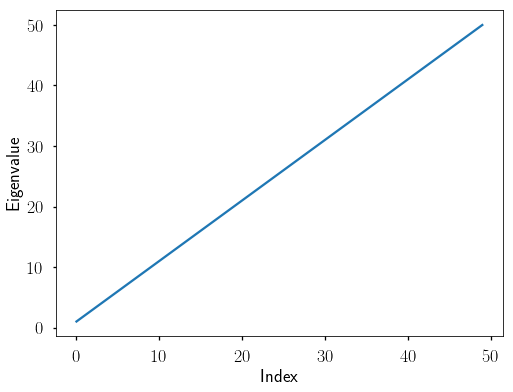

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(2e-2)),
     "BFGS": solvers.fo.BFGS(f, grad_f),
     "DFP": solvers.fo.DFP(f, grad_f),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -1.5976688497065514
Norm of gradient = 0.005921896480628395
	 Newton
Required tolerance achieved!
Convergence in 1 iterations
Function value = -1.597677075918243
Norm of gradient = 4.804537402782014e-14
	 CG quad
Required tolerance achieved!
Convergence in 36 iterations
Function value = -1.5976770759182295
Norm of gradient = 112.96343837618788
	 CG FR
Required tolerance achieved!
Convergence in 73 iterations
Function value = -1.5976770759181993
Norm of gradient = 8.739674096932931e-07
	 BB 1
Required tolerance achieved!
Convergence in 78 iterations
Function value = -1.597677075918221
Norm of gradient = 2.209667904728462e-07
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -1.5976770258690918
Norm of gradient = 0.0006021463426861488
	 BFGS
Required tolerance achieved!
Convergence in 49 iterations
Function value = -1.5976770759182286
Norm of gradient = 6.719547524394692e-07


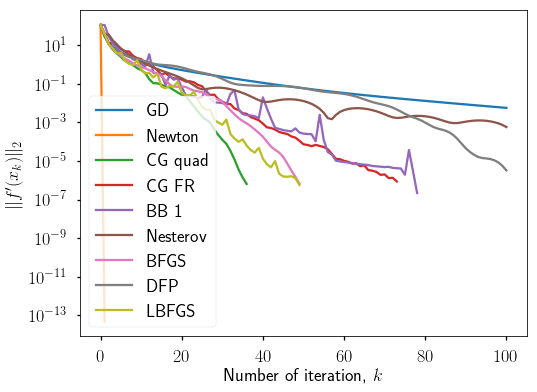

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [8]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
1.92 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Newton
92.4 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
784 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
5.72 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.26 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.79 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 BFGS
3.68 ms ± 90.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 DFP
7.06 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 LBFGS
5.01 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000005302


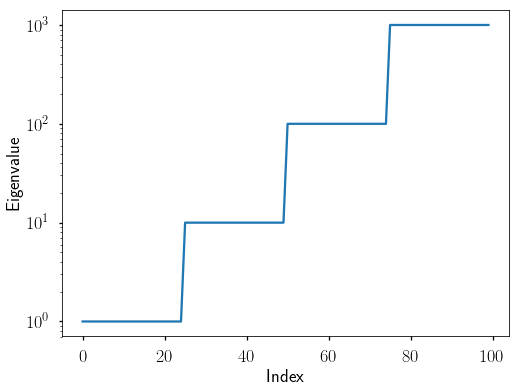

In [9]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [10]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [11]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3)),
     "BFGS": solvers.fo.BFGS(f, grad_f)
    }

In [12]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [13]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -10.237924708069698
Norm of gradient = 4.652317382878938
	 Newton
Required tolerance achieved!
Convergence in 1 iterations
Function value = -19.720504830583298
Norm of gradient = 1.2844011924512202e-12
	 CG quad
Required tolerance achieved!
Convergence in 5 iterations
Function value = -19.72050483058297
Norm of gradient = 1670.844571329451
	 CG FR
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -19.682821902029552
Norm of gradient = 0.7817267096853121
	 BB 1
Required tolerance achieved!
Convergence in 56 iterations
Function value = -19.720504830582986
Norm of gradient = 3.381325805750851e-07
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -16.711826617335905
Norm of gradient = 2.520522953599358
	 BFGS
Required tolerance achieved!
Convergence in 26 iterations
Function value = -19.7205048305831
Norm of gradient = 6.115000204646811e-09


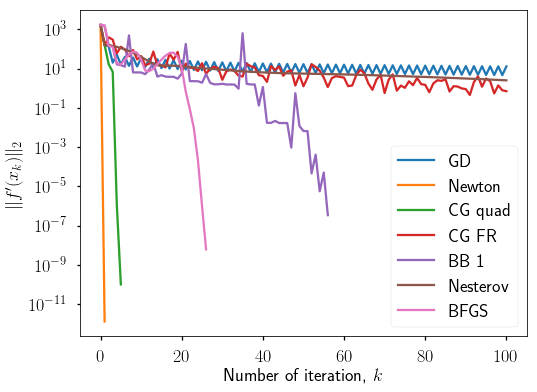

In [14]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [15]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
2.23 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
233 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG quad
176 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
18.4 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.03 ms ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
2.17 ms ± 48.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BFGS
3.94 ms ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Analytical center of the set of inequalities

In [39]:
n = 3000
m = 100
A = np.random.rand(m, n) * 10

In [40]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) \
                           + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.T / (1 - A.dot(x))**2).dot(A) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

class hess_matvec(object):
    def __init__(self, x):
        self._x = x
    
    def dot(self, y):
        d_part = y * 2 * (1 + self._x**2) / (1 - self._x**2)**2
        m_part = (A.T / (1 - A.dot(self._x))**2).dot(A.dot(y))
        return m_part + d_part

In [41]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3)),
     "Inexact Newton": solvers.so.InexactNewtonMethod(f, grad_f, hess_matvec, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "BFGS": solvers.fo.BFGS(f, grad_f),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [42]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [43]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=1)

	 GD Armijo
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6980812449372
Norm of gradient = 4.93897627005844e-07
	 Newton


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 14 iterations
Function value = -706.6980812449369
Norm of gradient = 1.534530607273504e-06
	 CG FR
Required tolerance achieved!
Convergence in 14 iterations
Function value = -706.6980812449176
Norm of gradient = 9.889177710890313e-06
	 BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6980812449333
Norm of gradient = 5.670323757219352e-06
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -704.4246031003629
Norm of gradient = 4.443146701986544
	 Inexact Newton
Required tolerance achieved!
Convergence in 16 iterations
Function value = -706.6980812449374
Norm of gradient = 3.7473204211706823e-07
	 GD Lipschitz
Required tolerance achieved!
Convergence in 36 iterations
Function value = -706.6980812449237
Norm of gradient = 7.54204165320729e-06
	 BFGS
Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.6980812449224
Norm of gradient = 7.960180833930167

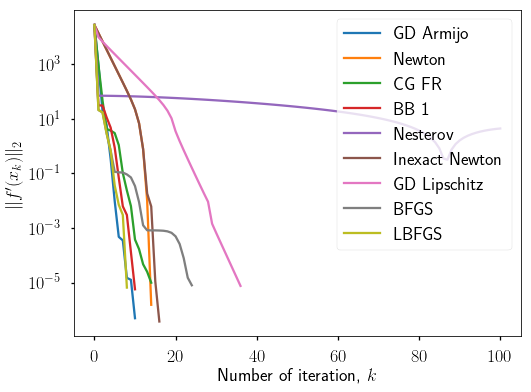

In [44]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [45]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD Armijo


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


18.2 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
4.16 s ± 744 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 CG FR


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


43.7 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
7.06 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
93.7 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Inexact Newton
121 ms ± 40.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 GD Lipschitz


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


56.1 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.81 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 LBFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


31.5 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Toy logistic regression with L2 regularization

In [46]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 1.9554695911245839


In [47]:
m_dict = {
     "GD Armijo": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-2)),
     "GD Lipschitz": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Lipschitz", rho=0.5, init_alpha=1.)),
     "LBFGS": solvers.fo.LBFGS(f, grad_f)
    }

In [48]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [49]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD Armijo
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.48951867451976205
Norm of gradient = 0.0026525026619486237
	 Newton
Required tolerance achieved!
Convergence in 17 iterations
Function value = 0.4895171240551331
Norm of gradient = 7.299521189343626e-06
	 CG FR
Required tolerance achieved!
Convergence in 57 iterations
Function value = 0.48951712405672676
Norm of gradient = 7.770872515373248e-06
	 BB 1
Required tolerance achieved!
Convergence in 54 iterations
Function value = 0.48951712405655934
Norm of gradient = 3.790496480624784e-06
	 Nesterov
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.4895174297458371
Norm of gradient = 0.0010690490342429755
	 GD Lipschitz
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = 0.4895273808617112
Norm of gradient = 0.005918198434450572
	 LBFGS
Required tolerance achieved!
Convergence in 28 iterations
Function value = 0.4895171240687222
Norm of gradient = 9.582621

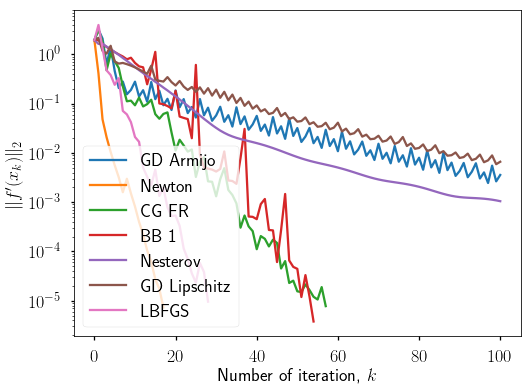

In [50]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [51]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD Armijo
99.1 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
49.9 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 CG FR
51.4 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
4.08 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
8.18 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 GD Lipschitz
48.2 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 LBFGS
19.5 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Non-smooth optimization
### Toy SVM classifier

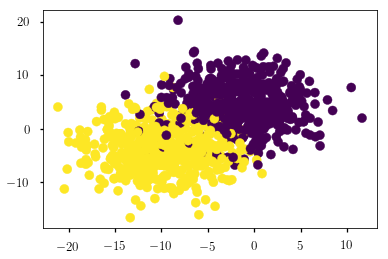

In [29]:
import sklearn.datasets as skldata
n = 2
m = 1000
C = 1
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4, random_state=1)
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], c=y)

### CVXPy solver

In [30]:
tol = 1e-5
max_iter = 300

In [31]:
w = cvxpy.Variable(n)
b = cvxpy.Variable()
obj = 0.5 * cvxpy.norm2(w)**2 + C * cvxpy.sum_entries(cvxpy.max_elemwise(0, 1 - cvxpy.mul_elemwise(y, (X * w - b))))
problem = cvxpy.Problem(cvxpy.Minimize(obj))
problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
b = b.value
w = np.array(w.value)
print("Optimal objective = {}".format(obj.value))
print("Train accuracy = {}".format(np.mean(y == np.sign(X.dot(w) - b).ravel())))

Optimal objective = 172.22400178238792
Train accuracy = 0.939


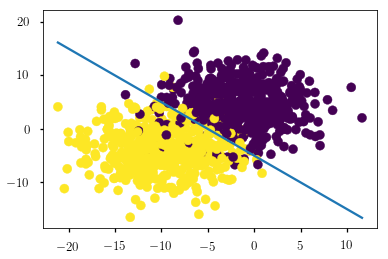

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.linspace(min(X[:, 0]), max(X[:, 0]))
plt.plot(x, (b - w[0] * x) / w[1])

In [33]:
def hinge_loss(w, X, y, C):
    return 0.5 * np.linalg.norm(w)**2 + C * np.sum(np.maximum(0, 1 - y * X.dot(w)))

def subgrad_hinge_loss(w, X, y, C):
    nnz = 1 - y * X.dot(w)
    subgrad_part = X * y[:, np.newaxis]
    return w - C * np.sum(subgrad_part[nnz > 0], axis=0)

X_ones = np.hstack((X, np.ones((m, 1))))
f = lambda x: hinge_loss(x, X_ones, y, C)
subgrad = lambda x: subgrad_hinge_loss(x, X_ones, y, C)

In [34]:
m_dict = {"Subgrad method": solvers.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
          "Dual averaging": solvers.fo.DualAveraging(f, subgrad, ss.InvIterStepSize(), ss.ScaledConstantStepSize(1.0)),
          "SM L": solvers.fo.SubgradientMethod(f, subgrad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-3, init_alpha=1))
         }

In [35]:
x0 = np.random.randn(n+1)

In [36]:
for key in m_dict:
    print("\t {}".format(key))
    x = m_dict[key].solve(x0, max_iter, tol, disp=True)
    print("Train accuracy = {}".format(np.mean(y == np.sign(X_ones.dot(x)))))

	 Subgrad method
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 882.2354081350045
Train accuracy = 0.941
	 Dual averaging
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 517.955530604666
Norm of gradient = 1129.1024766552302
Train accuracy = 0.761
	 SM L
Maximum iteration exceeds!
Convergence in 300 iterations
Function value = 174.83335461612904
Train accuracy = 0.94


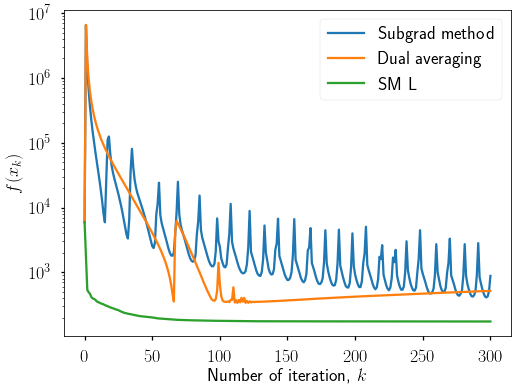

In [37]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([f(x) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [38]:
print("\t SCS CVXPy")
%timeit problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 SCS CVXPy
37.7 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Subgrad method
20.5 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Dual averaging
20.6 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 SM L
68.7 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
